# Module 2: Visual Interpretability of ColPali

In [10]:
!pip install scipy matplotlib transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 24.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.2/507.2 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.4.2
    Uninstalling safetensors-0.4.2:
      Successfully uninstalled safetensors-0.4.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np

def compute_similarity_map(query_token_vec, doc_vectors):
    """Compute similarity map for a single query token."""
    # Take only the 1024 patch embeddings (excluding instruction tokens)
    patch_vectors = doc_vectors[:1024]

    # Compute dot product similarity with all patches
    similarities = np.dot(patch_vectors, query_token_vec)

    # Reshape to 32×32 spatial grid
    return similarities.reshape(32, 32)

In [3]:
from fastembed import LateInteractionMultimodalEmbedding

# Load ColPali model
model = LateInteractionMultimodalEmbedding(
    model_name="Qdrant/colpali-v1.3-fp16"
)

# Load and embed a document image
image_path = "images/einstein-newspaper.jpg"
doc_vectors = next(model.embed_image([image_path]))

# Embed a query
query = "When did Einstein die?"
query_vectors = next(model.embed_text(query))

print(f"Document embeddings shape: {doc_vectors.shape}")  # (1030, 128)
print(f"Query embeddings shape: {query_vectors.shape}")    # (N, 128) where N = number of tokens

Document embeddings shape: (1030, 128)
Query embeddings shape: (19, 128)


In [4]:
def compute_all_similarity_maps(query_vectors, doc_vectors):
    """Compute similarity maps for all query tokens."""
    return np.array([
        compute_similarity_map(query_token_vec, doc_vectors)
        for query_token_vec in query_vectors
    ])

# Compute similarity maps
similarity_maps = compute_all_similarity_maps(query_vectors, doc_vectors)
print(f"Similarity maps shape: {similarity_maps.shape}")  # (N, 32, 32)

Similarity maps shape: (19, 32, 32)


In [5]:
from scipy.ndimage import zoom
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def create_heatmap_overlay(image, similarity_map, alpha=0.5):
    """Create a heatmap overlay on the original image."""
    # Ensure image is in RGB and resized to 448×448 (ColPali's input size)
    if isinstance(image, str):
        image = Image.open(image)
    image = image.convert("RGB").resize((448, 448))
    image_array = np.array(image)

    # Upsample similarity map from 32×32 to 448×448
    # zoom factor = 448/32 = 14
    # Convert to float64 as scipy.ndimage.zoom doesn't support all dtypes (e.g., float16)
    upsampled_map = zoom(similarity_map.astype(np.float64), 14, order=1)

    # Normalize to [0, 1] range
    min_val = upsampled_map.min()
    max_val = upsampled_map.max()
    if max_val > min_val:
        normalized_map = (upsampled_map - min_val) / (max_val - min_val)
    else:
        normalized_map = np.zeros_like(upsampled_map)

    # Apply colormap (using 'jet' for red=high, blue=low)
    heatmap = cm.jet(normalized_map)[:, :, :3]  # Remove alpha channel
    heatmap = (heatmap * 255).astype(np.uint8)

    # Blend with original image
    blended = (alpha * heatmap + (1 - alpha) * image_array).astype(np.uint8)

    return Image.fromarray(blended), normalized_map

In [6]:
def visualize_query_tokens(image_path, query, model, num_tokens_to_show=5):
    """Visualize similarity maps for each query token."""
    # Generate embeddings
    doc_vectors = next(model.embed_image([image_path]))
    query_vectors = next(model.embed_text(query))

    # Compute similarity maps
    similarity_maps = compute_all_similarity_maps(query_vectors, doc_vectors)

    # Load original image
    original_image = Image.open(image_path).convert("RGB").resize((448, 448))

    # Limit number of tokens to display
    n_tokens = min(len(similarity_maps), num_tokens_to_show)

    # Create figure
    fig, axes = plt.subplots(1, n_tokens + 1, figsize=(4 * (n_tokens + 1), 4))

    # Show original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Show heatmap for each token
    for i in range(n_tokens):
        overlay, _ = create_heatmap_overlay(original_image, similarity_maps[i])
        axes[i + 1].imshow(overlay)
        axes[i + 1].set_title(f"Token {i}")
        axes[i + 1].axis("off")

    plt.suptitle(f'Query: "{query}"', fontsize=14)
    plt.tight_layout()
    plt.show()

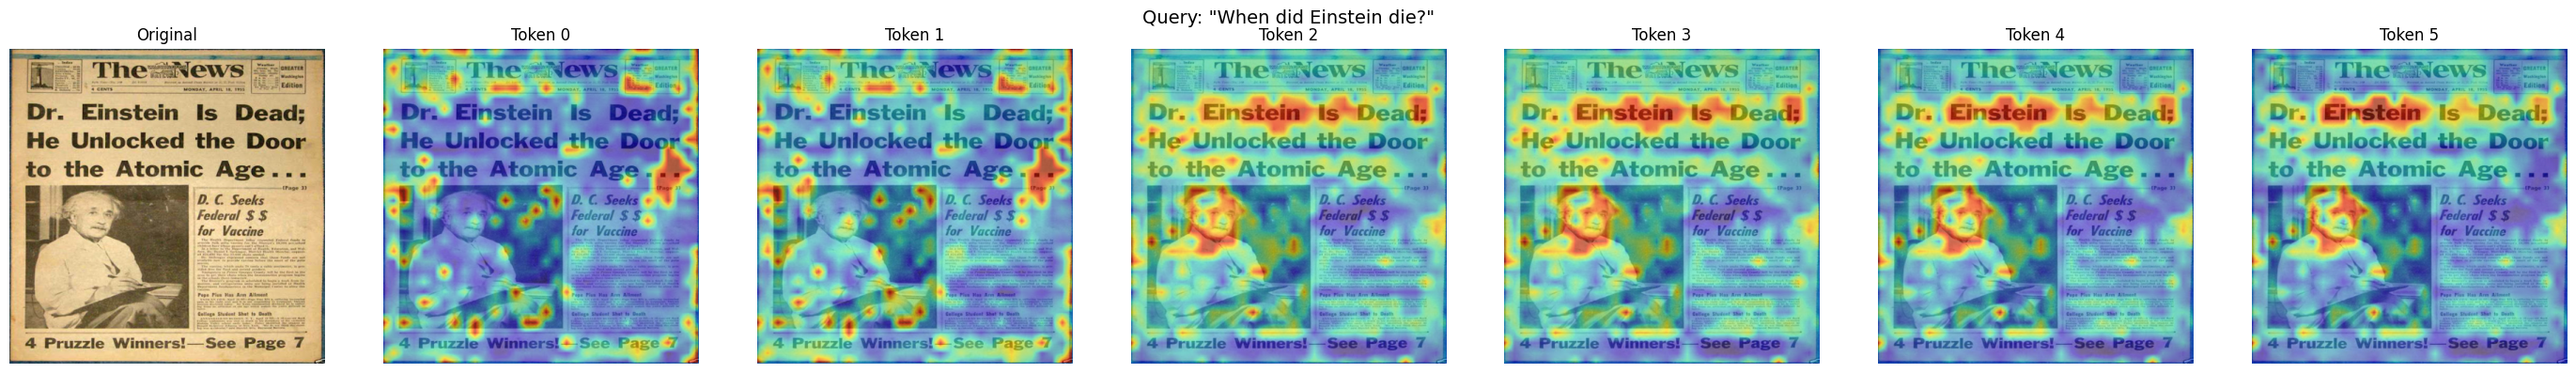

In [7]:
# Visualize what each token focuses on
visualize_query_tokens(
    "images/einstein-newspaper.jpg",
    "When did Einstein die?",
    model,
    num_tokens_to_show=6
)

In [8]:
def debug_search_result(image_path, query, model, tokenizer):
    """Debug why a document matched a query."""
    # Generate embeddings
    doc_vectors = next(model.embed_image([image_path]))
    query_vectors = next(model.embed_text(query))

    # Tokenize query to get actual token strings
    # ColPali uses "Query: " prefix internally
    query_with_prefix = f"Query: {query}"
    tokens = tokenizer.tokenize(query_with_prefix)

    # Compute MaxSim score
    similarities = np.dot(query_vectors, doc_vectors.T)
    max_sims = similarities.max(axis=1)
    total_score = max_sims.sum()

    print(f"Query: {query}")
    print(f"Total MaxSim Score: {total_score:.2f}")
    print(f"\nPer-token contributions:")

    # Show contribution of each token
    for i, (max_sim, token_sims) in enumerate(zip(max_sims, similarities)):
        # Find which patch this token matched best with
        best_patch_idx = token_sims[:1024].argmax()
        row, col = best_patch_idx // 32, best_patch_idx % 32
        # Display actual token text (fall back to index if out of range)
        token_str = tokens[i] if i < len(tokens) else f"[pad_{i}]"
        print(f"  '{token_str}': score={max_sim:.3f}, best match at patch ({row}, {col})")

    return total_score, max_sims

In [12]:
from transformers import AutoTokenizer

# Load tokenizer for ColPali (based on PaliGemma)
tokenizer = AutoTokenizer.from_pretrained("google/paligemma-3b-pt-224")

# Debug the search result
score, token_scores = debug_search_result(
    "images/financial-report.png",
    "bar chart showing revenue",
    model,
    tokenizer
)

Query: bar chart showing revenue
Total MaxSim Score: 14.21

Per-token contributions:
  'Query': score=1.000, best match at patch (4, 30)
  ':': score=0.864, best match at patch (30, 17)
  '▁bar': score=0.753, best match at patch (7, 25)
  '▁chart': score=0.765, best match at patch (7, 26)
  '▁showing': score=0.644, best match at patch (11, 16)
  '▁revenue': score=0.717, best match at patch (13, 17)
  '[pad_6]': score=0.858, best match at patch (13, 19)
  '[pad_7]': score=0.741, best match at patch (7, 2)
  '[pad_8]': score=0.756, best match at patch (7, 2)
  '[pad_9]': score=0.784, best match at patch (1, 20)
  '[pad_10]': score=0.845, best match at patch (7, 0)
  '[pad_11]': score=0.866, best match at patch (6, 12)
  '[pad_12]': score=0.886, best match at patch (4, 21)
  '[pad_13]': score=0.881, best match at patch (13, 10)
  '[pad_14]': score=0.768, best match at patch (8, 27)
  '[pad_15]': score=0.699, best match at patch (9, 27)
  '[pad_16]': score=0.701, best match at patch (9, 27

In [13]:
def compute_maxsim_contribution(query_vectors, doc_vectors):
    """Compute how much each patch contributes to the MaxSim score."""
    # Use only patch embeddings
    patch_vectors = doc_vectors[:1024]

    # Compute all pairwise similarities
    similarities = np.dot(query_vectors, patch_vectors.T)  # (n_query, 1024)

    # For each patch, take the maximum contribution across all query tokens
    # This shows which patches are most "useful" for any query token
    max_contribution = similarities.max(axis=0)  # (1024,)

    # Reshape to spatial grid
    contribution_map = max_contribution.reshape(32, 32)

    return contribution_map

In [16]:
def visualize_maxsim_contribution(image_path, query, model):
    """Visualize which patches contribute most to the MaxSim score."""
    # Generate embeddings
    doc_vectors = next(model.embed_image([image_path]))
    query_vectors = next(model.embed_text(query))

    # Compute contribution map
    contribution_map = compute_maxsim_contribution(query_vectors, doc_vectors)

    # Create visualization
    original_image = Image.open(image_path).convert("RGB").resize((448, 448))
    overlay, _ = create_heatmap_overlay(original_image, contribution_map)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(original_image)
    axes[0].set_title("Original Document")
    axes[0].axis("off")

    axes[1].imshow(overlay)
    axes[1].set_title(f"MaxSim Contribution\nQuery: \"{query}\"")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

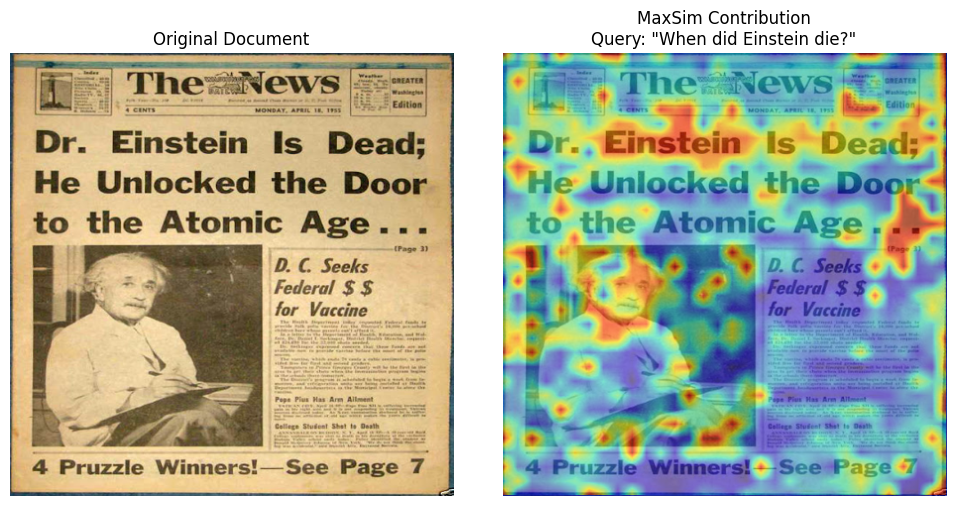

In [17]:
# Visualize overall contribution
visualize_maxsim_contribution(
    "images/einstein-newspaper.jpg",
    "When did Einstein die?",
    model
)